# Parallel Qubit Clustering - Large Batch

In this notebook, a large batch of the Parallel Qubit Processing experiment can be performed.

  0%|          | 0/20 [00:00<?, ?it/s]




Starting experiment Parallel Qubit [1 qubits, 256 shots, 100 iterations]


  0%|          | 0/20 [00:00<?, ?it/s]

Runtime for experiment Parallel Qubit [1 qubits, 256 shots, 100 iterations]: 45.15055936574936



Starting experiment Parallel Qubit [2 qubits, 256 shots, 100 iterations]


  0%|          | 0/20 [00:00<?, ?it/s]

Runtime for experiment Parallel Qubit [2 qubits, 256 shots, 100 iterations]: 51.02189084291458



Starting experiment Parallel Qubit [3 qubits, 256 shots, 100 iterations]


  0%|          | 0/20 [00:00<?, ?it/s]

Runtime for experiment Parallel Qubit [3 qubits, 256 shots, 100 iterations]: 44.331227004528046



Starting experiment Parallel Qubit [4 qubits, 256 shots, 100 iterations]


  0%|          | 0/20 [00:00<?, ?it/s]

Runtime for experiment Parallel Qubit [4 qubits, 256 shots, 100 iterations]: 38.92223408222198



Starting experiment Parallel Qubit [5 qubits, 256 shots, 100 iterations]


  0%|          | 0/20 [00:00<?, ?it/s]

Runtime for experiment Parallel Qubit [5 qubits, 256 shots, 100 iterations]: 39.478783309459686



Starting experiment Parallel Qubit [6 qubits, 256 shots, 100 iterations]


  0%|          | 0/20 [00:00<?, ?it/s]

Runtime for experiment Parallel Qubit [6 qubits, 256 shots, 100 iterations]: 43.89178775548935



Starting experiment Parallel Qubit [7 qubits, 256 shots, 100 iterations]


  0%|          | 0/20 [00:00<?, ?it/s]

Runtime for experiment Parallel Qubit [7 qubits, 256 shots, 100 iterations]: 50.87612315416336



Starting experiment Parallel Qubit [8 qubits, 256 shots, 100 iterations]


  0%|          | 0/20 [00:00<?, ?it/s]

Runtime for experiment Parallel Qubit [8 qubits, 256 shots, 100 iterations]: 66.02751258611679



Starting experiment Parallel Qubit [9 qubits, 256 shots, 100 iterations]


 30%|███       | 6/20 [10:10<23:27, 100.50s/it]

KeyboardInterrupt: 

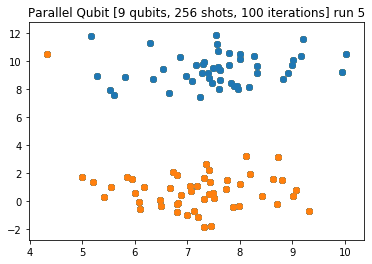

In [39]:
# =========================================================================
# Import all necessary libraries
# =========================================================================

# Special imports (necessary for backrefrencing to own class-type)
from __future__ import annotations

# Standard Python libraries
import time
import matplotlib.pyplot as plt
import math

# Numpy and SciPy
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment

# Qiskit
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import transpile
from qiskit import execute
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import ADAM
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info import state_fidelity

# Sklearn
from sklearn import datasets

# Other libraries
from tqdm import tqdm



# =========================================================================
# Utility functions
# =========================================================================

# Square a number
def sqr(x: float):
    return x * x

# Map a number 'a', which is the range between 'b' and 'c',
# to become in the range between 'd' and 'e'.
def map(a: float, b: float, c: float, d: float, e: float) -> float:
    return d + ((a - b)/(c - b)) * (e - d)



# =========================================================================
# DataPoints
# =========================================================================

# DataPoint class
# -> Provide framework around data-points in the dataset that helps
#    track changes throughout the algorithm.
class DataPoint:
    x: float
    y: float
    cluster: int
    fidelity: float

    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
        self.cluster = 0
        self.fidelity = 0

    def dist(self, o: DataPoint) -> float:
        return sqr(o.x - self.x) + sqr(o.y - self.y)
    
    def reset_fidelity(self):
        self.cluster = 0
        self.fidelity = 0
        
        
        
# =========================================================================
# Experiments
# =========================================================================

# ParallelQubitExperiment class
# -> Provide an easy way to execute multiple experiments in a row
class ParallelQubitExperiment:
    name: str
        
    # Experiment configuration
    dataset: [DataPoint]
    num_qubits: int
    num_shots: int
    num_iter: int
    optimizer = None
        
    # Information about the dataset
    xrange: [float]
    yrange: [float]
        
    # The number of optimization parameters
    num_params: int
    
    # Keep track of the number of circuits that is run under this experiment
    parallel_circuit_counter: int
    
    # The selected qiskit backend
    qiskit_backend = None
    
    # Initialization function: provide all necessary information
    # before starting the experiment.
    def __init__(self, name: str, data: [DataPoint], num_qubits: int, num_shots: int, num_iter: int, optimizer, num_params: int):
        self.name = name
        
        self.dataset = data
        
        # Determine the xmin/max and ymin/max
        self.xrange = [self.dataset[0].x, self.dataset[0].x]
        self.yrange = [self.dataset[0].y, self.dataset[0].y]
        
        for dp in self.dataset:
            if dp.x < self.xrange[0]:
                self.xrange[0] = dp.x
            if dp.x > self.xrange[1]:
                self.xrange[1] = dp.x
            if dp.y < self.yrange[0]:
                self.yrange[0] = dp.y
            if dp.y > self.yrange[1]:
                self.yrange[1] = dp.y
        
        self.num_qubits = num_qubits
        self.num_shots = num_shots
        self.num_iter = num_iter
        self.parallel_circuit_counter = 0
        
        # Install the optimizer
        self.optimizer = COBYLA(maxiter=self.num_iter, tol=0.00001)
        
        self.num_params = num_params
        
        # Select the Aer_Simulator backend
        self.qiskit_backend = Aer.get_backend("aer_simulator")
    
    # 
    # Methods
    #
    
    # [Private] Construct and run the variational circuit for the provided set of DataPoints.
    # Extract the 'counts': the number of times a qubit ended up in zero or one state.
    # Compute the fidelities from these counts.
    # Return the computed fidelities
    def __run_parallel_variational_circuit(self, dps: [DataPoint], params):
        # Declare a QuantumCircuit with the required number of qubits
        registers = [QuantumRegister(1) for i in range(min(len(dps), self.num_qubits))]
        
        q_circuit = QuantumCircuit(*registers)
        
        # Name the circuit
        q_circuit.name = "parallel_circuit_" + str(self.parallel_circuit_counter)
        self.parallel_circuit_counter += 1
        
        # Install the circuit
        # Initialize all qubits to state zero
        for i in registers:
            q_circuit.initialize([1, 0], i)
        
        # Install the unitary transformations
        for i in range(len(registers)):
            # 1: unitary transformation for data point properties (x, y)
            q_circuit.u(
                map(dps[i].x, self.xrange[0], self.xrange[1], 0, math.pi),
                map(dps[i].y, self.yrange[0], self.yrange[1], 0, math.pi),
                0,
                registers[i]
            )
            
            # 2: unitary transformation for the optimization parameters
            if len(params) == 1:
                q_circuit.u(params[0], 0, 0, registers[i])
            elif len(params) == 2:
                q_circuit.u(params[0], params[1], 0, registers[i])
            elif len(params) >= 3:
                q_circuit.u(params[0], params[1], params[2], registers[i])
                
        # Measure all qubits
        q_circuit.measure_all()
        
        # Run the circuit and obtain the result
        job_run = execute(q_circuit, backend=self.qiskit_backend, shots=self.num_shots)
        job_counts = job_run.result().get_counts(q_circuit)
        
        # Count the number of times the individual qubits read zero or one as
        # measurement outcome
        counts_zero = []
        counts_one  = []

        for i in range(len(dps)):
            counts_zero.append(0)
            counts_one.append(0)

        # Go over all the outcomes that qiskit encountered
        for key in job_counts:
            cnt = job_counts[key]
            
            # For each data point (that is connected to a qubit):
            # -> If, during this encounter, this qubit is '0', add the count to
            #    its zero-counter in the array. Likewise with '1'.
            for i in range(len(dps)):
                char = key[i]
                if char == '0':
                    counts_zero[i] += cnt
                elif char == '1':
                    counts_one[i] += cnt
                else:
                    print("UNEXPECTED MEASUREMENT OUTCOME!")

        # Calculate fidelities with reference states zero and one
        fidelities_with_zero = []

        # This is done by dividing the counts by the number of shots
        for i in range(len(dps)):
            fidelities_with_zero.append(float(counts_zero[i])/float(self.num_shots))

        # Before returning the fidelities for each data-point with zero state,
        # reverse the order of this array. Qubit follows a different order.
        fidelities_with_zero.reverse()
        return fidelities_with_zero
    
    
    # [Private] Calculate the cost-function for the provided set of parameters
    def __parallel_objective(self, params) -> float:
        # Start by pulling every data point through the circuit.
        # Create queues of data points, with max length the number of qubits
        circuit_queues = []
        
        queue = []
        for dp in self.dataset:
            queue.append(dp)
            if len(queue) >= self.num_qubits:
                circuit_queues.append(queue)
                queue = []
        if not len(queue) == 0:
            circuit_queues.append(queue)
            
        # For every data point, compute the fidelity with the zero-state
        # by using the queues we just made
        
        # Start by resetting the fidelities and cluster-assignments of all datapoints
        for dp in self.dataset:
            dp.reset_fidelity()
        
        datapoint_fid_with_zero = []
        
        for queue in circuit_queues:
            # Compute fidelities for this queue by using class function
            queue_fid_with_zero = self.__run_parallel_variational_circuit(queue, params)
            
            # In the order they're presented in, append these fidelities to the array
            # of data point-fidelities
            for fid in queue_fid_with_zero:
                datapoint_fid_with_zero.append(fid)
                
        # Now that we have the fidelities for each data point with zero state, compute
        # the value of the objective function
        total_cost = 0
    
        for i in range(len(self.dataset)):
            for j in range(len(self.dataset)):
                if not i == j:
                    point_dist = self.dataset[i].dist(self.dataset[j])

                    # Compute the objective function for reference state zero
                    cost_zero = point_dist * datapoint_fid_with_zero[i] * datapoint_fid_with_zero[j]

                    # Compute the objective function for reference state one
                    cost_one = point_dist * (1-datapoint_fid_with_zero[i]) * (1-datapoint_fid_with_zero[j])

                    # Add both costs to the total cost function
                    total_cost += cost_zero
                    total_cost += cost_one
                    
        # Iterate over all datapoints and update the cluster they belong to
        for i, dp in enumerate(self.dataset):
            if datapoint_fid_with_zero[i] > dp.fidelity:
                dp.fidelity = datapoint_fid_with_zero[i]
                dp.cluster = 0
            if 1-datapoint_fid_with_zero[i] > dp.fidelity:
                dp.fidelity = 1-datapoint_fid_with_zero[i]
                dp.cluster = 1
        
        # We're done coputing the final cost! Return it!
        return total_cost
    
    # [Public] Render experiment name
    def render_name(self):
        return self.name + " [" + str(self.num_qubits) + " qubits, " + str(self.num_shots) + " shots, " + str(self.num_iter) + " iterations]"
    
    # [Public] Run the experiment a specified amount of times.
    #
    # - Render a scatter plot of the resulting cluster and save it on disk.
    # - Record the time each experiment takes. Average the runtimes and return it.
    def run(self, times: int) -> float:
        average_runtime = 0
        
        print("\n\n")
        print("Starting experiment " + self.render_name())
        
        for i in tqdm(range(times)):            
            # Record start time
            start_time = time.time()
        
            # Prepare random initial optimization parameters
            params_init = np.random.rand(self.num_params)

            # Perform the optimization and obtain the optimal parameters
            params_optimal = self.optimizer.minimize(fun=self.__parallel_objective, x0=params_init).x
            
            # Calculate the run-time and add it to the average
            run_time = time.time() - start_time
            average_runtime += run_time
            
            # Separate the points based on the cluster they're in
            clusters = [[], []]
            
            for dp in self.dataset:
                clusters[dp.cluster].append(dp)
            
            # Make a scatter plot of this result
            for c in clusters:
                plt.scatter(
                    [dp.x for dp in c],
                    [dp.y for dp in c]
                )
            
            # Give the plot the name of this experiment, together with the run index
            plt.title(self.render_name() + " run " + str(i))
            
            # Save the figure to disk
            plt.savefig("./Images/" + self.render_name() + ".png")
            
            
        # Finally, divide the sum of runtimes by the number of runs to obtain the average
        # and return it.
        average_runtime /= times
        return average_runtime

    
# =========================================================================
# Setup and run the experiments
# =========================================================================

# Select a dataset
selected_dataset = datasets.make_blobs(n_samples=100, centers=2, random_state=8)

data_points = []
for point in selected_dataset[0]:
    x = point[0]
    y = point[1]
    data_points.append(DataPoint(x, y))

# Setup the experiments
experiments = [
    ParallelQubitExperiment(
        name="Parallel Qubit",
        data=data_points,
        num_qubits=1,
        num_shots=256,
        num_iter=100,
        optimizer=None,
        num_params=3
    ),
    ParallelQubitExperiment(
        name="Parallel Qubit",
        data=data_points,
        num_qubits=2,
        num_shots=256,
        num_iter=100,
        optimizer=None,
        num_params=3
    ),
    ParallelQubitExperiment(
        name="Parallel Qubit",
        data=data_points,
        num_qubits=3,
        num_shots=256,
        num_iter=100,
        optimizer=None,
        num_params=3
    ),
    ParallelQubitExperiment(
        name="Parallel Qubit",
        data=data_points,
        num_qubits=4,
        num_shots=256,
        num_iter=100,
        optimizer=None,
        num_params=3
    ),
    ParallelQubitExperiment(
        name="Parallel Qubit",
        data=data_points,
        num_qubits=5,
        num_shots=256,
        num_iter=100,
        optimizer=None,
        num_params=3
    ),
    ParallelQubitExperiment(
        name="Parallel Qubit",
        data=data_points,
        num_qubits=6,
        num_shots=256,
        num_iter=100,
        optimizer=None,
        num_params=3
    ),
    ParallelQubitExperiment(
        name="Parallel Qubit",
        data=data_points,
        num_qubits=7,
        num_shots=256,
        num_iter=100,
        optimizer=None,
        num_params=3
    ),
    ParallelQubitExperiment(
        name="Parallel Qubit",
        data=data_points,
        num_qubits=8,
        num_shots=256,
        num_iter=100,
        optimizer=None,
        num_params=3
    )
]
    
# Run all experiments 20 times
for e in experiments:
    runtime = e.run(20)
    print("Runtime for experiment " + e.render_name() + ": " + str(runtime))


